<a href="https://colab.research.google.com/github/pumazzo/ML-ISS2025/blob/main/Lezione_5_ISS_CIFAR_classification_convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Load the MNIST dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ["airplanes", "cars", "birds", "cats", "deer", "dogs", "frogs", "horses", "ships", "trucks"]

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

100%|██████████| 170498071/170498071 [00:12<00:00, 13121830.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


shape of an image :  torch.Size([3, 32, 32])
label for the image :  6


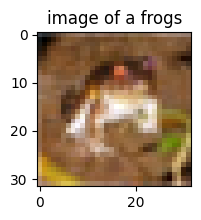

In [ ]:
#plot an element of the trainset using plt
img, label = trainset[0]
print("shape of an image : " , img.shape)
print("label for the image : ",  label)

def plot_tensor_image(img, label):
  # normalize
  img = (img - img.amin(dim = (-1,-2),keepdim=True))/(img.amax(dim = (-1,-2),keepdim=True)-img.amin(dim = (-1,-2),keepdim=True))

  f, ax = plt.subplots(1,figsize=(2,2))
  ax.imshow(img.squeeze().numpy().transpose(1,2,0), cmap = "Greys",vmin=0,vmax=1)# img is a tensor, it is better to convert to numpy (using the method .numpy() )
  ax.set_title("image of a {}".format(classes[label]))
plot_tensor_image(img, label)

## Mini - batches with the dataloader.
We need to sample B elements from our dataset (without repetitions) to form a batch.

We can use the dataloader from pyTorch:
- it will take a dataset and a batch size (B) as an argument
- each time it is called it will return B elements (random, if shuffle == True) from the dataset.
- when the elements are exausted the dataloader will reset itself.



In [ ]:
for minibatch in trainloader:# loop over batches
  batch_of_images,  batch_of_labels = minibatch # unpack the batch
  print("shape of the batch : ",batch_of_images.shape)
  break # exit from the cicle, this way only the first batch will be printed

shape of the batch :  torch.Size([128, 3, 32, 32])


# To build our neural network we will use pyToch layers:
- it is the Base class for all neural network modules.
- Our models should also subclass this class.
- In general Modules will have parameters that we want to optimize, they will perform operations on some input and they will be "derivable" using the pytorch "gradient"



## This is an example of a class and a hint about class interitance
We are going to use this "way" to exploit pytorch modules to buid our models

In [ ]:
class Parent():# this is a Class
  def __init__(self):
    self.name = None
    self.introduction= "Hi,son . "
  def give_name(self,name):# this is a method of Parent class
    self.name =name
  def speak(self):
    if self.name is not None:
      print(self.introduction+"I am {}".format(self.name))
    else:
      print("give name first")

class Child(Parent):# this is a child class. It has the same methods of Parent
  def __init__(self):# Init is replaced. Everthing else is the same
    self.name = None
    self.introduction= "Hi,Mama . "

In [ ]:
mama=Parent()# create a instance of class Parent
mama.give_name("Marta")# use a method (give name is a "function" inside the class)
son=Child()# create a instance of class Child
son.give_name("Andrea")# we can use methods from the parent class

mama.speak()# He can speak!
son.speak()# He also can speak!

Hi,son . I am Marta
Hi,Mama . I am Andrea


In [ ]:
# layers can be used and defined, they are not very usefull on their own

In [ ]:
# define a conv layer with one output
my_conv_layer = nn.Conv2d(in_channels = 3, out_channels = 1, kernel_size = 3, stride = 1, padding = 0, dilation = 1)

In [ ]:
# now
filtered_img = my_conv_layer(img.unsqueeze(0)).detach()# We need to add the bach dimention, # detach is used to remove the "gradients"

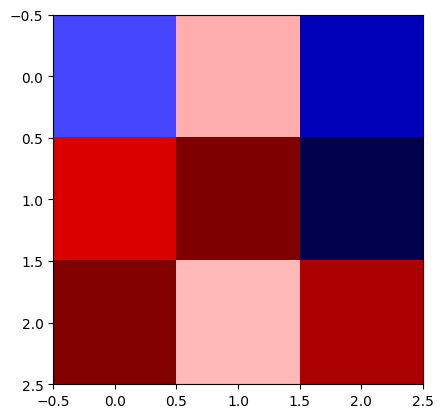

In [ ]:
operation = my_conv_layer.weight.detach().numpy().squeeze()
plt.imshow(operation[0], cmap = "seismic")

In [ ]:
filtered_img.shape

torch.Size([1, 1, 30, 30])

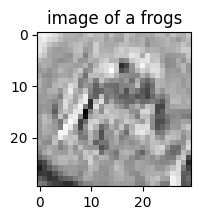

In [ ]:
def plot_filter_image(img, label):

  f, ax = plt.subplots(1,figsize=(2,2))
  ax.imshow(img.squeeze().numpy(), cmap = "Greys")# img is a tensor, it is better to convert to numpy (using the method .numpy() )
  ax.set_title("image of a {}".format(classes[label]))


plot_filter_image(filtered_img, label)# this is a random filter

## We can define by hand an operator and put it inside the conv layer.
Usually a convolutional operation over an image is also called a filter.

We can copy something from [HERE](https://matematicas.uam.es/~fernando.chamizo/dark/d_simimf.html)

Usually we want that our neural network learns its own filter using gradient descend optimization but I want to show that "human enegineered filters" are just operation made on pixels

In [ ]:
# we can define by hand an operator and put it inside the conv layer.
sharpen_filter = [[[0,-1,0],[-1,5,-1],[0,-1,0]],
                  [[0,-1,0],[-1,5,-1],[0,-1,0]],
                  [[0,-1,0],[-1,5,-1],[0,-1,0]]
                  ]

In [ ]:
torch_sharpen = torch.tensor(sharpen_filter, dtype=my_conv_layer.weight.dtype)

In [ ]:
torch_sharpen.shape

torch.Size([3, 3, 3])

In [ ]:
# use the hand crafted filter instead
my_conv_layer.weight = nn.Parameter(torch_sharpen.unsqueeze(0))# we need to put batch and channel dimention

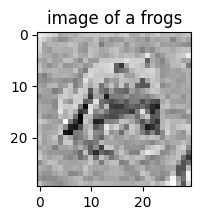

In [ ]:
filtered_img = my_conv_layer(img.unsqueeze(0)).detach()
plot_filter_image(filtered_img, label)# this is a sharpen filter

In [ ]:
# Define the CNN model
import torch.nn.functional as F

class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        # Dropout layer
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        # Flatten the tensor
        x = x.view(-1, 64 * 4 * 4)
        # Apply dropout
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:



# Create an instance of the CNN model
model = CIFAR10Classifier()


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)

# this is a useful tool to print the structure of the model in a keras-like fashion ...
from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(3,32,32))
else:
  summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
           Dropout-7                 [-1, 1024]               0
            Linear-8                  [-1, 128]         131,200
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
           Linear-11                   [-1, 10]             650
Total params: 163,690
Trainable params: 163,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [ ]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

model.to(device)

# of GPUs available:  1
First GPU type:  NVIDIA A100-SXM4-40GB
Computation device: cuda



CIFAR10Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
# Training loop
num_epochs = 15

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
      images = images.to(device)
      labels = labels.to(device)


      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}')

# Testing loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {(correct/total)*100:.2f}%')

KeyboardInterrupt: ignored